# Adversarial Input

[A Brief Introduction to Adversarial Examples](https://gradientscience.org/intro_adversarial/)

## Szukanie przykładów za pomocą problemów całkowitoliczbowych

Rozpatrzmy następującą sieć nauczoną liczyć funkcję XOR:

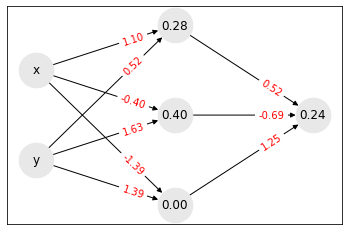

In [68]:
import networkx
g = networkx.DiGraph()
g.add_edges_from([('x', 'd1'), ('x', 'd2'), ('x', 'd3'), ('y', 'd1'), ('y', 'd2'), ('y', 'd3'), ('d1', 'o'), ('d2', 'o'), ('d3', 'o')])
layers = {'x': {'layer': 0}, 'y': {'layer': 0}, 'd1': {'layer': 1}, 'd2': {'layer': 1}, 'd3': {'layer': 1}, 'o': {'layer': 2}}
networkx.set_node_attributes(g, layers)
pos = networkx.multipartite_layout(g, subset_key='layer')
networkx.draw_networkx(g, pos=pos, with_labels=True, node_color='#e8e8e8', labels={'x': 'x', 'y': 'y', 'd1': '0.28', 'd2': '0.40', 'd3': '0.00', 'o': '0.24'}, node_size=1200)
edge_labels = networkx.draw_networkx_edge_labels(g,pos=pos,edge_labels={('x', 'd1'): '1.10', ('x', 'd2'): '-0.40', ('x', 'd3'): '-1.39',
                                                                        ('y', 'd1'): '0.52', ('y', 'd2'): '1.63', ('y', 'd3'): '1.39',
                                                                        ('d1', 'o'): '0.52', ('d2', 'o'): '-0.69', ('d3', 'o'): '1.25'},font_color='red', label_pos=0.3)

Funkcja aktywacji to ReLU. Jest to sieć licząca wartość funkcji XOR.

In [93]:
def ReLU(x):
    return 0 if x < 0 else x

def d1(x, y):
    return ReLU(1.10 * x + 0.52 * y + 0.28)
def d2(x, y):
    return ReLU(-0.40 * x + 1.63 * y + 0.40)
def d3(x, y):
    return ReLU(-1.39 * x + 1.39 * y)

def o(d1, d2, d3):
    return ReLU(0.52 * d1 - 0.69 * d2 + 1.25 * d3 + 0.24)

def model(x, y):
    return o(d1(x, y), d2(x, y), d3(x, y))

for x, y in [[0,0], [0,1], [1,0], [1,1]]:
    print(f'{x}, {y} -> {model(x,y)}')

0, 0 -> 0.109600000000000
0, 1 -> 0.992800000000000
1, 0 -> 0.957600000000000
1, 1 -> 0.103300000000000


Wykonywane tu są operacje:

```
d1 = ReLU(1.10 * x + 0.52 * y + 0.28)
d2 = ReLU(-0.40 * x + 1.63 * y + 0.40)
d3 = ReLU(-1.39 * x + 1.39 * y)
o = ReLU(0.52 * d1 - 0.69 * d2 + 1.25 * d3 + 0.24)
```

Dla argumentu $x \in [a, b]$ funkcję $r = ReLU(x)$ możemy zapisać warunkami (zakładamy, że $a < 0 < b$)

$r \geq 0$

$r \geq x$

$r \leq x - (1 - t)a$

$r \leq t b$

$t \in \{0, 1\}$

(binarna zmienna $t$ to zmienna pomocnicza).

W naszym przypadku na pewno $1.10 x + 0.52 y + 0.28 \geq 0$, więc $d1_ = 1.10 x + 0.52 y + 0.28$ i $d_1 \in [0, 1.90]$.

Podobnie $-0.40x + 1.63y + 0.40 \geq 0$, więc $d_2 = -0.40x + 1.63y + 0.40$ i $d_2 \in [0, 2.03]$.

Za to $-1.39x + 1.39y \in [-1.39, 1.39]$, czyli $d_3 \in [0, 1.39]$.

Podobnie $0.52 d_1 - 0.69d_2 + 1.25 d_3 + 0.24 \in [-1.65, 2.97]$

Stąd program całkowitoliczbowy

$x + y \to \min$

$d_1 = 1.10 x + 0.52y + 0.28$

$d_2 = -0.4 x + 1.63y + 0.4$

$d_3 \geq 0$

$d_3 \geq -1.39x + 1.39y$

$d_3 \leq -1.39x + 1.39y - (1-t_1) \cdot (-1.39)$

$d_3 \leq t_1 \cdot 1.39$

$t_1 \in \{ 0, 1 \}$

$o \geq 0$

$o \geq 0.52 d_1 - 0.69 d_2 + 1.25 d_3 + 0.24$

$o \leq 0.52 d_1 - 0.69 d_2 + 1.25 d_3 + 0.24 - (1 - t_2) (-1.65)$

$o \leq t_2 \cdot 2.97$

$t_2 \in \{ 0, 1 \}$

$o \geq \frac 12$

In [89]:
p = MixedIntegerLinearProgram(maximization=False, solver='GLPK')
i = p.new_variable(nonnegative=True)
i.set_max(1)
x = i[0]
y = i[1]
d = p.new_variable(nonnegative=True)
o_ = p.new_variable(nonnegative=True)
o = o_[0]
t = p.new_variable(binary=True)

p.set_objective(x + y)
p.add_constraint(d[1] == 1.10 * x + 0.52 * y + 0.28)
p.add_constraint(d[2] == -0.4 * x + 1.63 * y + 0.4)
p.add_constraint(d[3] >= -1.39 * x + 1.39 * y)
p.add_constraint(d[3] <= -1.39 * x + 1.39 * y - (1 - t[1]) * (-1.39))
p.add_constraint(d[3] <= t[1] * 1.39)
p.add_constraint(o >= 0.52 * d[1] - 0.69 * d[2] + 1.25 * d[3] + 0.24)
p.add_constraint(o <= 0.52 * d[1] - 0.69 * d[2] + 1.25 * d[3] + 0.24 - (1 - t[2]) * (-1.65))
p.add_constraint(o <= t[2] * 2.97)
p.add_constraint(o >= 0.5)

In [90]:
p.solve()

0.4420289855072466

In [91]:
p.get_values(i)

{0: 0.0, 1: 0.4420289855072466}

In [94]:
print(model(0.0, 0.4420))

0.499974400000000
